In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
from math import log, sqrt, exp

import warnings
warnings.filterwarnings("ignore")

In [2]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [3]:
def IRR_0(K, m, N):
    # implementation of IRR(K) function
    value = 1/(K) * ( 1.0 - 1/(1 + K/m)**(N*m))
    return value

def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/(K)*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/(K)*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative

In [4]:
# def payoff second derivative function
def payoff_2(K, m, N):
    payoff = ((-IRR_2(K, m, N) * K - 2 * IRR_1(K, m, N)) / (IRR_0(K, m, N) ** 2)) + \
    ((2 * (IRR_1(K, m, N) ** 2) * K) / IRR_0(K, m, N) ** 3)
    return payoff

In [5]:
def Black76Call(F, K, sigma, T):
    d1 = (log(F / K) + (1 / 2) * (sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    V =  F * norm.cdf(d1) - K * norm.cdf(d2)
    return V

def Black76Put(F, K, sigma, T):
    d1 = (log(F / K) + (1 / 2) * (sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    V = K * norm.cdf(-d2) - F * norm.cdf(-d1)
    return V

In [6]:
# integrand of receiver price part
def integrand_put(K, m, N, sigma, df, F, T):
    h = payoff_2(K, m, N)
    V_put = df * Black76Put(F, K, sigma, T)
    return h * V_put
# integrand of payer price part
def integrand_call(K, m, N, sigma, df, F, T):
    h = payoff_2(K, m, N)
    V_call = df * Black76Call(F, K, sigma, T)
    return h * V_call

In [7]:
Discount_Factor_df = pd.read_csv('Discount_Factors.csv')
Discount_Factor_df.set_index('Tenor', drop=True, inplace=True)

## Question 1: Use SABR Model to Value the CMS Products 

### PV of a leg receiving CMS10y semi-annually over the next 5 years 

In [8]:
def forward_swap_rate(expiry, tenor, m, N):
    if type(expiry) == str: 
        expiry = float(expiry.replace('Y', ''))
    tenor = int(tenor.replace('Y', ''))
    fixed_leg = m * (Discount_Factor_df.iloc[int(N*expiry):int(N*(expiry+tenor)), 0].values.sum())
    float_leg = 0
    for k in range(int(N * expiry), int(N * (expiry + tenor))):
        float_leg = float_leg + (Discount_Factor_df.iloc[k, 0] * \
                                ((Discount_Factor_df.iloc[k-1, 1] - Discount_Factor_df.iloc[k, 1]) / Discount_Factor_df.iloc[k, 1]))
    forward_swap_rate = float_leg / fixed_leg
    return forward_swap_rate

In [9]:
freq_lst = ['0.5Y', '1Y', '1.5Y', '2Y', '2.5Y', '3Y', '3.5Y', '4Y', '4.5Y', '5Y']
tenor_l = ['10Y']

In [10]:
# compute forward swap rate for next 5 years with tenor as 10 years
swap_rate = []
m = 0.5
N = 2
for i in freq_lst:
    for j in tenor_l:
        S = forward_swap_rate(i, j, m, N)
        swap_rate.append(S)

In [11]:
alpha = pd.read_csv('Alpha_SABR.csv')
alpha1 = alpha.copy()
alpha_value = alpha1.iloc[:-1, -1].values

rho = pd.read_csv('Rho_SABR.csv')
rho1 = rho.copy()
rho_value = rho1.iloc[:-1, -1].values

nu = pd.read_csv('Nu_SABR.csv')
nu1 = nu.copy()
nu_value = nu1.iloc[:-1, -1].values

In [12]:
cms_df = pd.DataFrame({'freq': freq_lst, 
                       'swap_rate': swap_rate, 
                       'OIS_DF':Discount_Factor_df.iloc[:10, 0]})
cms_df['alpha'] = np.nan
cms_df['rho'] = np.nan
cms_df['nu'] = np.nan

In [13]:
cms_df['alpha'][0] = alpha_value[0]
cms_df['alpha'][1] = alpha_value[0]
cms_df['alpha'][9] = alpha_value[1]

cms_df['rho'][0] = rho_value[0]
cms_df['rho'][1] = rho_value[0]
cms_df['rho'][9] = rho_value[1]

cms_df['nu'][0] = nu_value[0]
cms_df['nu'][1] = nu_value[0]
cms_df['nu'][9] = nu_value[1]

In [14]:
# linear interpolation for calibrated SABR model parameters
cms_df['alpha'] = cms_df['alpha'].interpolate()
cms_df['rho'] = cms_df['rho'].interpolate()
cms_df['nu'] = cms_df['nu'].interpolate()

In [15]:
cms_df

,freq,swap_rate,OIS_DF,alpha,rho,nu
Tenor,,,,,,
0.5,0.5Y,0.037845,0.998752,0.180561,-0.377000,0.646509
1.0,1Y,0.038428,0.997009,0.180561,-0.377000,0.646509
1.5,1.5Y,0.039020,0.995270,0.180436,-0.388195,0.625974
2.0,2Y,0.039634,0.993531,0.180311,-0.399389,0.605439
2.5,2.5Y,0.040200,0.991773,0.180187,-0.410584,0.584904
3.0,3Y,0.040788,0.990015,0.180062,-0.421779,0.564369
3.5,3.5Y,0.041412,0.988066,0.179937,-0.432973,0.543834
4.0,4Y,0.042062,0.986117,0.179812,-0.444168,0.523299
4.5,4.5Y,0.042831,0.984150,0.179688,-0.455362,0.502765


In [16]:
beta = 0.9
# compute cms rate
cms_rate = []
for i in range(len(freq_lst)):
    F = cms_df['swap_rate'].iloc[i]
    T = (i + 1) / 2
    N = 10
    m = 2
    sigma = SABR(F, F, T, cms_df['alpha'].iloc[i], beta, cms_df['rho'].iloc[i], cms_df['nu'].iloc[i])
    integral_term1 = quad(lambda x: integrand_put(x, m, N, sigma, IRR_0(F, N, m) , F, T), 0, F)
    integral_term2 = quad(lambda x: integrand_call(x, m, N, sigma, IRR_0(F, N, m), F, T), F, np.inf)
    rate = F + sum(integral_term1 + integral_term2)
    cms_rate.append(rate)

In [17]:
cms_df['CMS_rate'] = cms_rate

In [18]:
cms_df.to_csv('CMS_Rate_10y.csv')

In [19]:
# calculate the PV of leg of CMS product
PV = []
freq = 0.5
for i in range(len(freq_lst)):
    pv = freq * cms_df['OIS_DF'].iloc[i] * cms_df['CMS_rate'].iloc[i]
    PV.append(pv)
sum(PV)
print('The PV of a Leg Receiving CMS10y Semi-Annually Over the Next 5 Years is', sum(PV))

The PV of a Leg Receiving CMS10y Semi-Annually Over the Next 5 Years is 0.20304196105699154


###  PV of a leg receiving CMS2y quarterly over the next 10 years

In [20]:
def forward_swap_rate2(expiry, tenor, m, N):
    if type(expiry) == str: 
        expiry = float(expiry.replace('Y', ''))
    tenor = int(tenor.replace('Y', ''))
    fixed_leg = m * (Discount_Factor_df2.iloc[int(N*expiry):int(N*(expiry+tenor)), 0].values.sum())
    float_leg = 0
    for k in range(int(N * expiry), int(N * (expiry + tenor))):
        float_leg = float_leg + (Discount_Factor_df2.iloc[k, 0] * \
                                ((Discount_Factor_df2.iloc[k-1, 1] - Discount_Factor_df2.iloc[k, 1]) / Discount_Factor_df2.iloc[k, 1]))
    forward_swap_rate = float_leg / fixed_leg
    return forward_swap_rate

In [21]:
## Because the day count fraction be quarter annually
## thus we need to change the discount factor to be quarter annually
## then we need to interpolate the necessary missing discount factors
Discount_Factor_df2 = pd.DataFrame()
tenor_lst2 = np.linspace(0.25, 12.5, 50)
Discount_Factor_df2['Tenor'] = tenor_lst2
Discount_Factor_df2.set_index('Tenor', drop=True, inplace=True)
Discount_Factor_df2['OIS_DF'] = np.nan
Discount_Factor_df2['LIBOR_DF']= np.nan

In [22]:
Discount_Factor_df2['OIS_DF'] = Discount_Factor_df['OIS_DF']
Discount_Factor_df2['LIBOR_DF'] = Discount_Factor_df['LIBOR_DF']

In [23]:
Discount_Factor_df2['OIS_DF'] = Discount_Factor_df2['OIS_DF'].interpolate(limit_direction = \
                                                                          'both')
Discount_Factor_df2['LIBOR_DF'] = Discount_Factor_df2['LIBOR_DF'].interpolate(limit_direction = \
                                                                              'both')

In [24]:
freq_lst2 = np.linspace(0.25, 10, 40)
tenor_l2 = ['2Y']

In [25]:
swap_rate2 = []
m = 0.25
N = 4
for i in freq_lst2:
    for j in tenor_l2:
        S = forward_swap_rate2(i, j, m, N)
        swap_rate2.append(S)

In [26]:
alpha_value2 = alpha1.iloc[:, -1].values

rho_value2 = rho1.iloc[:, -1].values

nu_value2 = nu1.iloc[:, -1].values

In [27]:
cms_df2 = pd.DataFrame({'freq': freq_lst2, 
                       'swap_rate': swap_rate2, 
                       'OIS_DF':Discount_Factor_df2.iloc[:40, 0]})
cms_df2['alpha'] = np.nan
cms_df2['rho'] = np.nan
cms_df2['nu'] = np.nan

In [28]:
# cms_df2['alpha'][0] = alpha_value2[0]
cms_df2['alpha'][1] = alpha_value2[0]
cms_df2['alpha'][5] = alpha_value2[1]
cms_df2['alpha'][10] = alpha_value2[2]

# cms_df2['rho'][0] = rho_value2[0]
cms_df2['rho'][1] = rho_value2[0]
cms_df2['rho'][5] = rho_value2[1]
cms_df2['rho'][10] = rho_value2[2]


# cms_df2['nu'][0] = nu_value2[0]
cms_df2['nu'][1] = nu_value2[0]
cms_df2['nu'][5] = nu_value2[1]
cms_df2['nu'][10] = nu_value2[2]


In [29]:
cms_df2['alpha'] = cms_df2['alpha'].interpolate(limit_direction = 'both')
cms_df2['rho'] = cms_df2['rho'].interpolate(limit_direction = 'both')
cms_df2['nu'] = cms_df2['nu'].interpolate(limit_direction = 'both')

In [30]:
beta = 0.9
# cms rate computation
cms_rate2 = []
for i in range(len(freq_lst2)):
    F = cms_df2['swap_rate'].iloc[i]
    T = (i + 1) / 4
    N = 2
    m = 4
    sigma = SABR(F, F, T, cms_df2['alpha'].iloc[i], beta, cms_df2['rho'].iloc[i], cms_df2['nu'].iloc[i])
    print
    integral_term1 = quad(lambda x: integrand_put(x, m, N, sigma, IRR_0(F, N, m) , F, T), 0, F)
    integral_term2 = quad(lambda x: integrand_call(x, m, N, sigma, IRR_0(F, N, m), F, T), F, np.inf)
    rate = F + sum(integral_term1 + integral_term2)
    cms_rate2.append(rate)

In [31]:
cms_df2['CMS_rate'] = cms_rate2

In [32]:
# calculate the PV of leg of CMS product
PV2 = []
freq = 0.25
for i in range(len(freq_lst2)):
    pv = freq * cms_df2['OIS_DF'].iloc[i] * cms_df2['CMS_rate'].iloc[i]
    PV2.append(pv)
sum(PV2)
print('The PV of a Leg Receiving CMS10y Semi-Annually Over the Next 5 Years is', sum(PV2))

The PV of a Leg Receiving CMS10y Semi-Annually Over the Next 5 Years is 0.38932460068991026


## Question 2: Compare Forward Swap Rates and CMS Rates

In [33]:
expiry_lst = [1, 5, 10]
tenor_lst = [1, 2, 3, 5, 10]

In [34]:
swap_rate_df = pd.read_csv('forward_swap_rate.csv')
swap_rate_df.set_index('tenor', drop=True, inplace=True)
swap_rate_df2 = pd.read_csv('forward_swap_rate2.csv')

In [35]:
swap_rate_df

,1Y,5Y,10Y
tenor,,,
1Y,0.032007,0.039274,0.042189
2Y,0.033259,0.040075,0.043116
3Y,0.034011,0.040072,0.044097
5Y,0.035255,0.041093,0.046249
10Y,0.038428,0.043634,0.053458


In [36]:
beta = 0.9
cms_rate3 = []
# compute the cms rate for the swaption from previous part with different tenor and expiry
for i in range(len(expiry_lst)):
    for j in range(len(tenor_lst)):
        F = swap_rate_df.T.iloc[i, j]
        T = expiry_lst[i]
        N = tenor_lst[j]
        m = 2
        sigma = SABR(F, F, T, alpha.iloc[i, j+1], beta, rho.iloc[i, j+1], nu.iloc[i, j+1])
        integral_term1 = quad(lambda x: integrand_put(x, m, N, sigma, IRR_0(F, N, m) , F, T), 0, F)
        integral_term2 = quad(lambda x: integrand_call(x, m, N, sigma, IRR_0(F, N, m), F, T), F, np.inf)
        rate = F + sum(integral_term1 + integral_term2)
        cms_rate3.append(rate)

In [37]:
swap_rate_df2['CMS_Rate'] = cms_rate3
swap_rate_df2.drop('Unnamed: 0', axis = 1, inplace=True)
index = ['1x1', '1x2', '1x3', '1x5', '1x10', '5x1', '5x2', '5x3', 
        '5x5', '5x10', '10x1', '10x2', '10x3', '10x5', '10x10']
swap_rate_df2.index = index

In [38]:
# present a dataframe to show the difference
swap_rate_df2

,Forward_Swap_Rate,CMS_Rate
1x1,0.032007,0.032082
1x2,0.033259,0.033377
1x3,0.034011,0.034140
1x5,0.035255,0.035362
1x10,0.038428,0.038546
5x1,0.039274,0.040231
5x2,0.040075,0.041189
5x3,0.040072,0.041171
5x5,0.041093,0.041960
5x10,0.043634,0.044494


In [39]:
forward_swap_rate = swap_rate_df2['Forward_Swap_Rate']

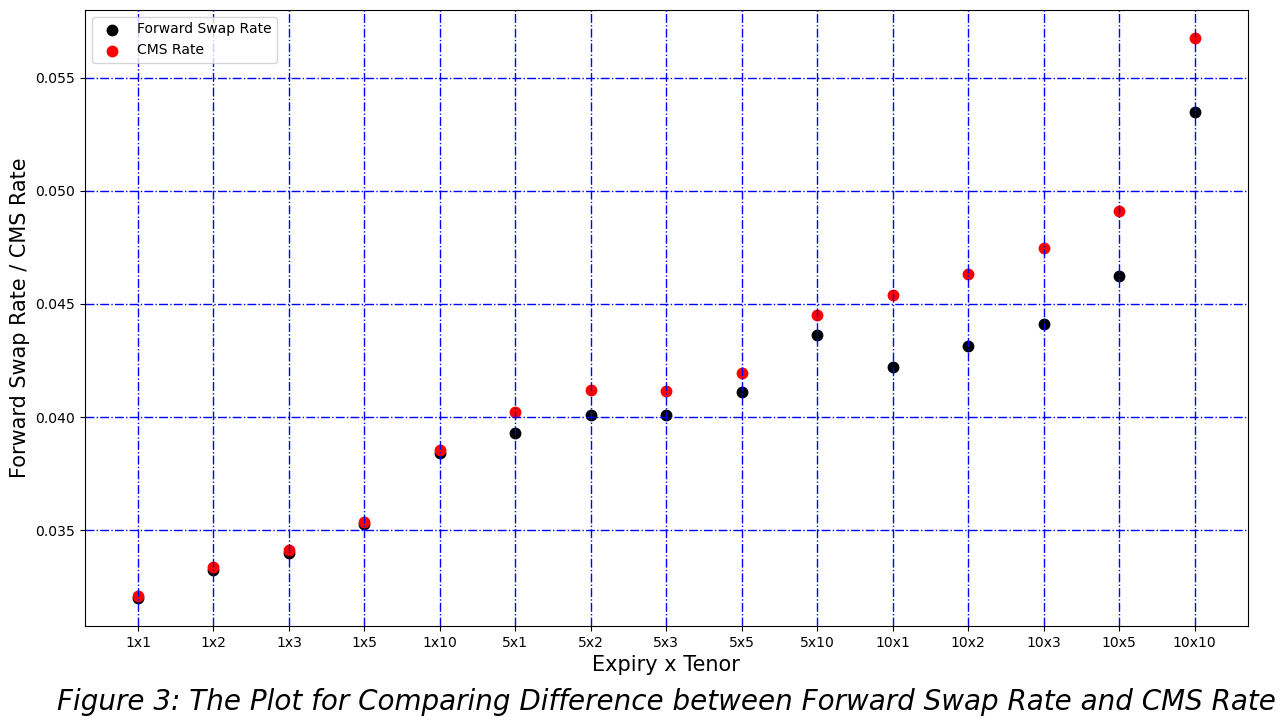

In [40]:
# Plot the Difference between Forward Swap rate and CMS rate
plt.figure(figsize = (15, 8))
plt.scatter(index, forward_swap_rate, color = 'black', linewidth = 2.5, label = 'Forward Swap Rate')
plt.scatter(index, cms_rate3, color = 'red', linewidth = 2.5, label = 'CMS Rate')
plt.grid(color='blue', linewidth = 1, linestyle = '-.')
plt.title(label = "Figure 3: The Plot for Comparing Difference between Forward Swap Rate and CMS Rate", 
         y = -0.15, 
          fontstyle = 'italic', 
         fontsize = 20)
plt.ylabel('Forward Swap Rate / CMS Rate', fontsize = 15)
plt.xlabel('Expiry x Tenor', fontsize = 15)
plt.legend(loc = 'upper left')
plt.savefig("The Plot for Comparing Difference between Forward Swap Rate and CMS Rate.png")

plt.show()